In [ ]:
# https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/disaggregation_and_metrics.ipynb

# Disaggregation

In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

In [2]:
rcParams['figure.figsize'] = (13, 6)

### Dividing data into train and test set

In [3]:
# train = DataSet('/data/redd.h5')
# test = DataSet('/data/redd.h5')
train = DataSet('../../dataset/redd/redd.h5')
test = DataSet('../../dataset/redd/redd.h5')

Let us use building 1 for demo purposes

In [4]:
building = 1

Let's split data at April 30th

In [5]:
train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

### Visualizing the data

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


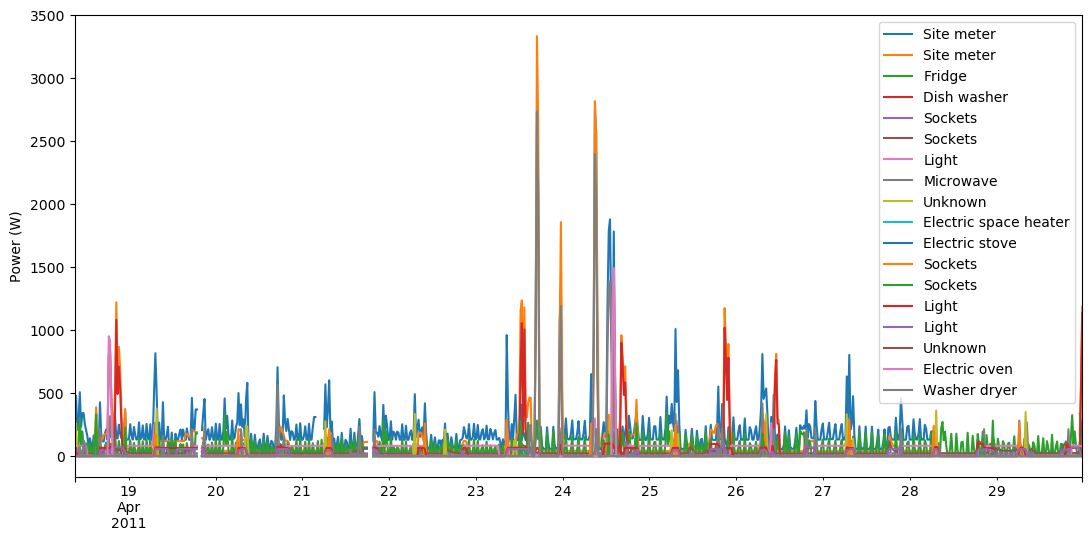

In [6]:
train_elec.plot()

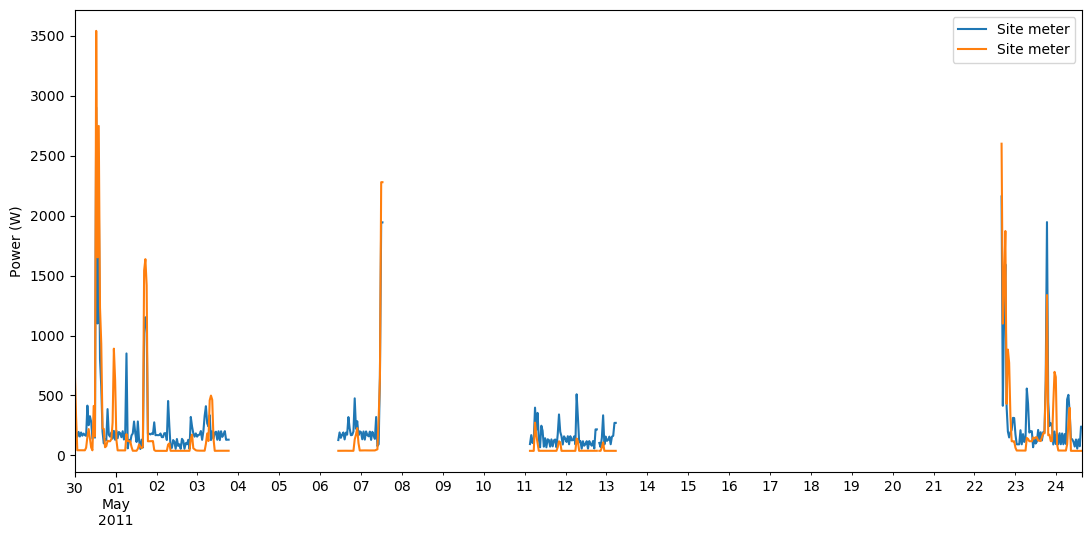

In [7]:
test_elec.mains().plot()

REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

In [8]:
fridge_meter = train_elec['fridge']

In [9]:
fridge_df = next(fridge_meter.load())

In [10]:
fridge_df.head()

physical_quantity,power
type,active
2011-04-18 09:22:13-04:00,6.0
2011-04-18 09:22:16-04:00,6.0
2011-04-18 09:22:20-04:00,6.0
2011-04-18 09:22:23-04:00,6.0
2011-04-18 09:22:26-04:00,6.0


In [11]:
mains = train_elec.mains()

In [12]:
mains_df = next(mains.load())

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [13]:
mains_df.head()

physical_quantity,power
type,apparent
2011-04-18 09:22:09-04:00,342.820007
2011-04-18 09:22:10-04:00,344.559998
2011-04-18 09:22:11-04:00,345.140015
2011-04-18 09:22:12-04:00,341.679993
2011-04-18 09:22:13-04:00,341.029999


Since, both of these are sampled at different frequencies, we will downsample both to 1 minute resolution. We will also select the top-5 appliances in terms of energy consumption and use them for training our FHMM and CO models.

### Selecting top-5 appliances

In [14]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [15]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

### Training and disaggregation

#### A function to disaggregate the mains data to constituent appliances and return the predictions

In [16]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

#### Train using 2 benchmarking algorithms -  Combinatorial Optimisation (CO) and Factorial Hidden Markov Model (FHMM)

In [17]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])
   

********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Done training!
Runtime = 0.6058971881866455 seconds.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge

Using prettier labels!

In [18]:
appliance_labels = [m.label() for m in gt.columns.values]

In [19]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

#### Taking a look at the ground truth of top 5 appliance power consumption

In [20]:
gt.head()

,Fridge,Light,Sockets,Microwave,Dish washer
2011-04-30 00:00:00-04:00,6.000000,76.133331,30.566668,4.0,1132.033325
2011-04-30 00:02:00-04:00,6.000000,76.206894,28.551723,4.0,1131.517212
2011-04-30 00:04:00-04:00,6.000000,76.099998,28.233334,4.0,1132.066650
2011-04-30 00:06:00-04:00,6.100000,76.900002,28.500000,4.0,1038.866699
2011-04-30 00:08:00-04:00,6.612903,81.032257,24.193548,4.0,205.387100


In [21]:
predictions['CO'].head()

,Fridge,Light,Sockets,Microwave,Dish washer
2011-04-30 00:00:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:02:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:04:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:06:00-04:00,57.0,81.0,0.0,0.0,1069.0
2011-04-30 00:08:00-04:00,0.0,81.0,72.0,0.0,221.0


In [22]:
predictions['FHMM'].head()

,Fridge,Light,Sockets,Microwave,Dish washer
2011-04-30 00:00:00-04:00,6.0,81.0,22.0,1324.0,0.0
2011-04-30 00:02:00-04:00,6.0,2.0,22.0,1324.0,0.0
2011-04-30 00:04:00-04:00,6.0,2.0,22.0,1324.0,0.0
2011-04-30 00:06:00-04:00,6.0,2.0,22.0,1324.0,0.0
2011-04-30 00:08:00-04:00,123.0,139.0,22.0,96.0,0.0


### Plotting the predictions against the actual usage

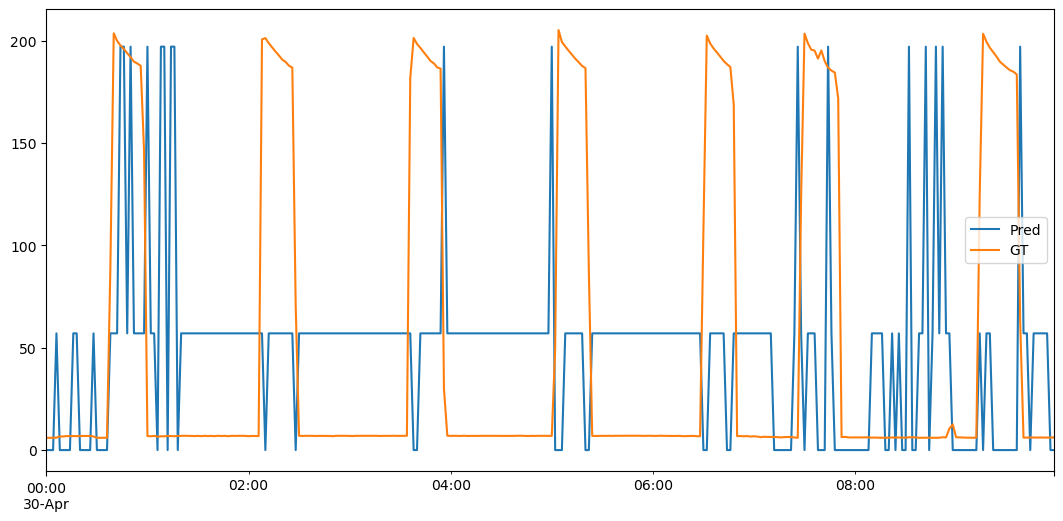

In [23]:
predictions['CO']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

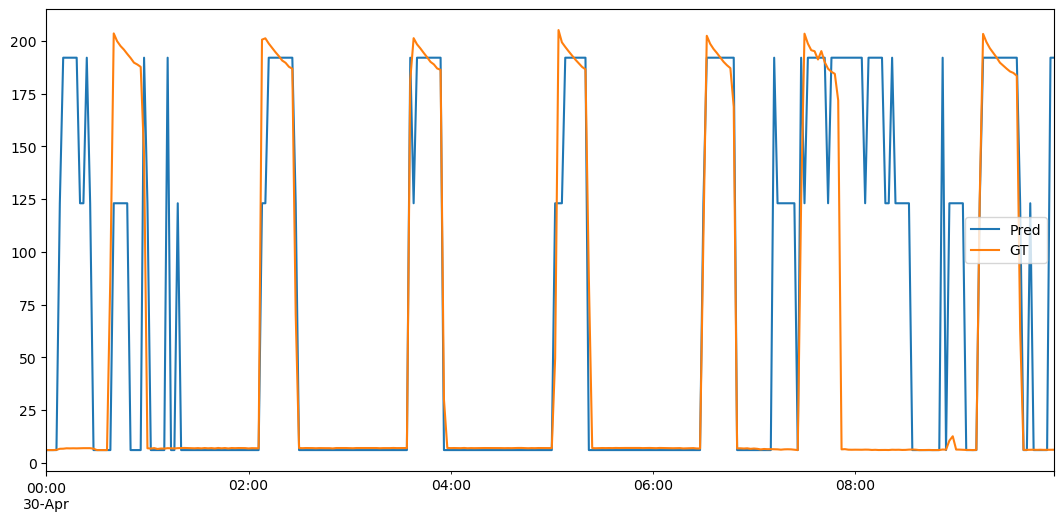

In [24]:
predictions['FHMM']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

### Comparing NILM algorithms (CO vs FHMM)

`nilmtk.utils.compute_rmse` is an extended of the following, handling both missing values and labels better:
```python
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
```

In [25]:
? nilmtk.utils.compute_rmse

Signature:  nilmtk.utils.compute_rmse(ground_truth, predictions, pretty=True)
Docstring:
Compute the RMS error between the time-series of appliance
ground truth values and predicted values.

Parameters
----------
ground_truth : `pandas.DataFrame` containing the ground truth series 
              for the appliances.

predictions : `pandas.DataFrame` containing the predicted time-series
              for each appliance. If a appliance is present in 
              `ground_truth` but absent in `predictions` (or only
              contains NA values), it is not listed in the output.

pretty : If `True`, tries to use the appliance labels if possible. If
         a type of appliance is present more than once, resulting in
         duplicate labels, building and instance number are added 
         to differentiate them. 

Returns
-------
pandas.Series with the RMSe for each appliance
File:      /nilmtk/nilmtk/utils.py
Type:      function

In [26]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

,CO,FHMM
Fridge,98.562111,81.572914
Light,107.654175,76.467770
Sockets,30.175222,19.448145
Microwave,270.826904,298.300187
Dish washer,249.187363,203.673703
